In [1]:
# Importing Libraries

In [30]:
%matplotlib inline
import pandas as pd
import numpy as np

In [31]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [32]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [33]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [34]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [35]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [36]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [38]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [39]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [40]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [41]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [42]:
# Initializing parameters
epochs = 40
batch_size = 16
n_hidden = 64

In [43]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [44]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [45]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

# Model 1 using single layer LSTM

In [46]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [47]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [48]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/40
7352/7352 [==============================] - 128s 17ms/step - loss: 1.3176 - acc: 0.4354 - val_loss: 1.2771 - val_acc: 0.4231
Epoch 2/40
7352/7352 [==============================] - 121s 16ms/step - loss: 1.0810 - acc: 0.5249 - val_loss: 1.0293 - val_acc: 0.5623
Epoch 3/40
7352/7352 [==============================] - 120s 16ms/step - loss: 1.0043 - acc: 0.5706 - val_loss: 0.9337 - val_acc: 0.5914
Epoch 4/40
7352/7352 [==============================] - 121s 17ms/step - loss: 0.8061 - acc: 0.6556 - val_loss: 0.9256 - val_acc: 0.6634
Epoch 5/40
7352/7352 [==============================] - 121s 16ms/step - loss: 0.8041 - acc: 0.6891 - val_loss: 0.7388 - val_acc: 0.7204
Epoch 6/40
7352/7352 [==============================] - 121s 16ms/step - loss: 0.6223 - acc: 0.7737 - val_loss: 0.7278 - val_acc: 0.7553
Epoch 7/40
7352/7352 [==============================] - 122s 17ms/step - loss: 0.5494 - acc: 0.8085 - val_loss: 0.5763 - val_acc: 

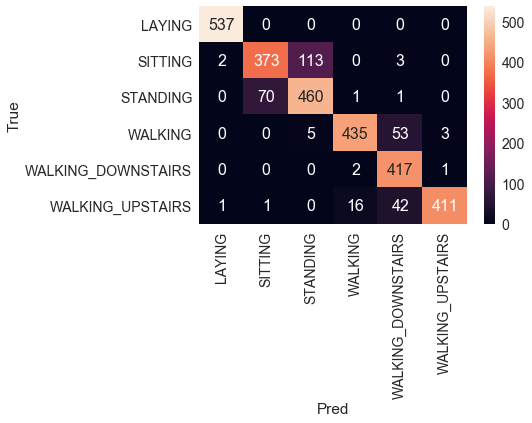

In [49]:
# Confusion Matrix
import seaborn as sns
df_cm=pd.DataFrame(confusion_matrix(Y_test, model.predict(X_test)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [50]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 8s 3ms/step


In [51]:
score

[0.7452502556916386, 0.8934509670851714]

Test score: 0.7452502556916386
Test accuracy: 0.8934509670851714


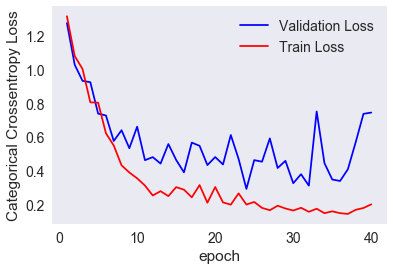

In [52]:
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

### We can improve our model by taking dropout to 0.7 and increasing LSTM units to 64 and the accuracy is 92.12%  which is good 

# Model 2 with 2 LSTM layers

In [53]:
# Initiliazing the sequential model
model1 = Sequential()
# Configuring the parameters
model1.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
model1.add(LSTM(64,input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model1.add(Dropout(0.85))
# Adding a dense output layer with sigmoid activation
model1.add(Dense(n_classes, activation='sigmoid'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Compiling the model
model1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [55]:
# Training the model
history=model1.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/40
7352/7352 [==============================] - 245s 33ms/step - loss: 1.2330 - acc: 0.4961 - val_loss: 0.8934 - val_acc: 0.5945
Epoch 2/40
7352/7352 [==============================] - 242s 33ms/step - loss: 0.9581 - acc: 0.5819 - val_loss: 0.8123 - val_acc: 0.5921
Epoch 3/40
7352/7352 [==============================] - 240s 33ms/step - loss: 0.8228 - acc: 0.6181 - val_loss: 0.7358 - val_acc: 0.6176
Epoch 4/40
7352/7352 [==============================] - 239s 32ms/step - loss: 0.7712 - acc: 0.6383 - val_loss: 0.7636 - val_acc: 0.6233
Epoch 5/40
7352/7352 [==============================] - 243s 33ms/step - loss: 0.7668 - acc: 0.6405 - val_loss: 0.8339 - val_acc: 0.6193
Epoch 6/40
7352/7352 [==============================] - 243s 33ms/step - loss: 0.7610 - acc: 0.6481 - val_loss: 0.7079 - val_acc: 0.6315
Epoch 7/40
7352/7352 [==============================] - 241s 33ms/step - loss: 0.7526 - acc: 0.6530 - val_loss: 0.7855 - val_acc: 

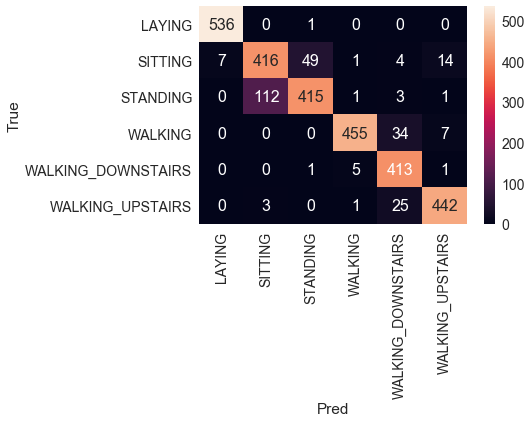

In [56]:
# Confusion Matrix
df_cm=pd.DataFrame(confusion_matrix(Y_test, model1.predict(X_test)))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [46]:
score = model1.evaluate(X_test, Y_test)

2947/2947 [==============================] - 17s 6ms/step


In [47]:
score

[0.5955817617565524, 0.9009161859518154]

Test score: 0.7452502556916386
Test accuracy: 0.8934509670851714


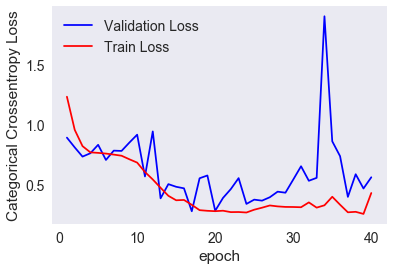

In [57]:
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# we got accuracy of 90.09% with 2  LSTM layers